![SX1276](img/tabela.png)

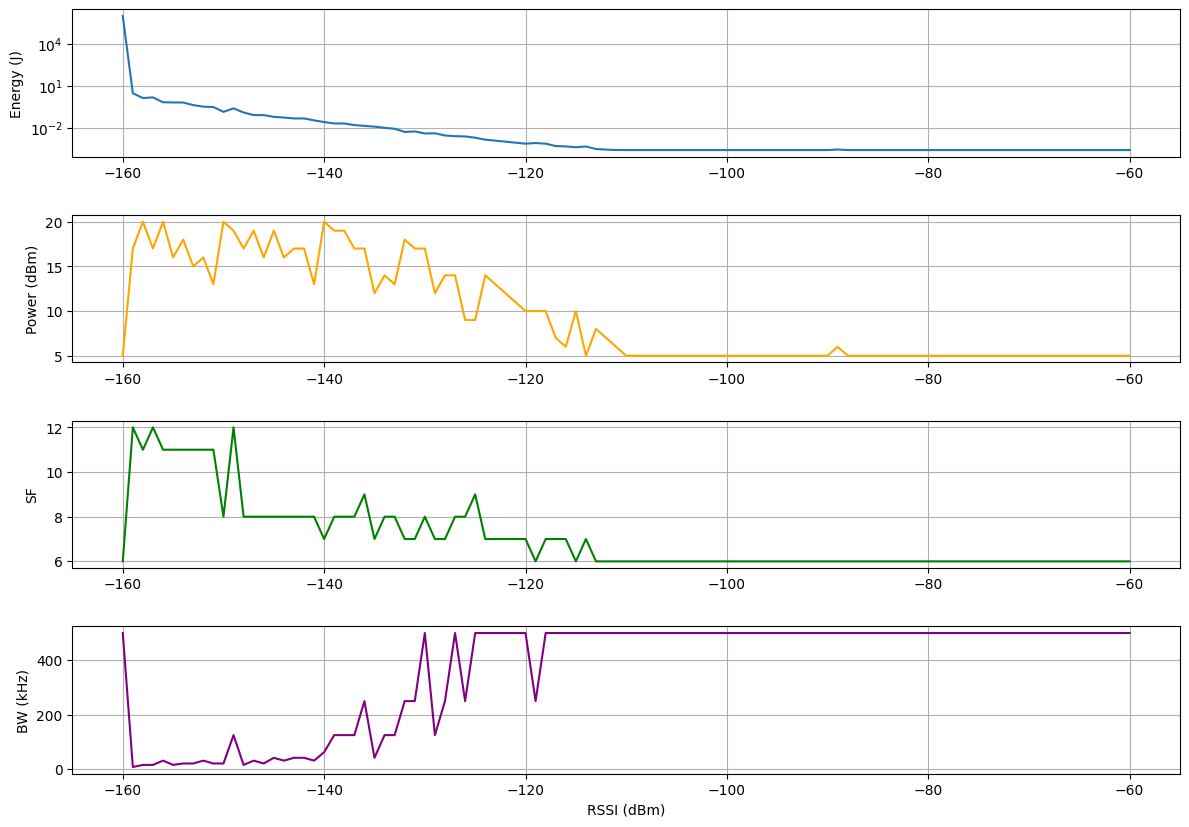

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
import random
import multiprocessing
import functools
from dataclasses import dataclass

# === 1. CONFIGURAÇÕES ===
power_options = list(range(2, 21))
sf_options = list(range(6, 13))
bw_options = [7.8, 10.4, 15.6, 20.8, 31.25, 41.7, 62.5, 125.0, 250.0, 500.0]
cr_options = [5, 6, 7, 8]

PAYLOAD_BYTES = 20
RSSI_MARGIN_MIN = 6
POP_SIZE = 100
N_GEN = 100
PREAMBLE_SYMS = 8.0
IH = 0
CRC = 1
DE = 0

@dataclass
class LoRaParams:
    power: int
    sf: int
    bw: float
    cr: int

# === 2. MODELO DE SENSIBILIDADE ===
def calculate_sensitivity(sf, bw):
    sensitivity_table = {
        (6, 125.0): -118, (7, 125.0): -123, (8, 125.0): -126, (9, 125.0): -129, (10, 125.0): -132, (11, 125.0): -134, (12, 125.0): -136,
        (6, 250.0): -115, (7, 250.0): -120, (8, 250.0): -123, (9, 250.0): -125, (10, 250.0): -128, (11, 250.0): -130, (12, 250.0): -133,
        (6, 500.0): -111, (7, 500.0): -116, (8, 500.0): -119, (9, 500.0): -122, (10, 500.0): -125, (11, 500.0): -128, (12, 500.0): -130,
        (6, 62.5): -121, (7, 62.5): -126, (8, 62.5): -129, (9, 62.5): -132, (10, 62.5): -135, (11, 62.5): -137, (12, 62.5): -139,
        (6, 10.4): -131, (7, 10.4): -134, (8, 10.4): -138, (11, 10.4): -146,
        (11, 7.8): -145, (12, 7.8): -148
    }
    key = (sf, bw)
    if key in sensitivity_table:
        return sensitivity_table[key]

    known = [(k[1], v) for k, v in sensitivity_table.items() if k[0] == sf]
    if not known:
        raise ValueError(f"No sensitivity data for SF={sf}")
    known.sort()
    for i in range(len(known) - 1):
        bw0, s0 = known[i]
        bw1, s1 = known[i + 1]
        if bw0 <= bw <= bw1:
            return np.interp(bw, [bw0, bw1], [s0, s1])
    return known[-1][1] if bw > known[-1][0] else known[0][1]

# === 2B. TABELA POTÊNCIA x CORRENTE ===
def power_to_current(power):
    # Polinômio ajustado com base nos valores do datasheet
    coeffs = [10.768, -1.689, 0.153, 0.00076]  # Ajuste de grau 3 (obtido por curve fitting)
    return max(0, coeffs[0] + coeffs[1]*power + coeffs[2]*power**2 + coeffs[3]*power**3)

# === 3. TEMPO DE TRANSMISSÃO ===
def symbol_rate(sf, bw):
    return (bw * 1000) / (2 ** sf)

def symbol_time(sf, bw):
    return 1 / symbol_rate(sf, bw)

def airtime(sf, bw, cr, payload_bytes):
    tsym = symbol_time(sf, bw)
    t_preamble = (PREAMBLE_SYMS + 4.25) * tsym
    numerator = 8 * payload_bytes - 4 * sf + 28 + 16 * CRC - 20 * IH
    denominator = 4 * (sf - 2 * DE)
    n_payload = 8 + max(int(np.ceil(numerator / denominator)) * (cr + 4), 0)
    t_payload = n_payload * tsym
    return t_preamble + t_payload

# === 4. FUNÇÃO DE AVALIAÇÃO ===
def evaluate(ind, rssi_observed):
    power, sf, bw, cr = ind
    if sf not in sf_options or bw not in bw_options or cr not in cr_options or power not in power_options:
        return (1e9,)

    sensitivity = calculate_sensitivity(sf, bw)
    path_loss = abs(rssi_observed)
    rssi_at_rx = power - path_loss
    margin = rssi_at_rx - sensitivity

    time_on_air = airtime(sf, bw, cr, PAYLOAD_BYTES)
    current_ma = power_to_current(power)
    voltage = 3.3
    energy = (current_ma / 1000) * voltage * time_on_air

    if margin < RSSI_MARGIN_MIN:
        energy += 1e6

    return (energy,)

# === 5. CONFIGURAÇÃO DE DEAP ===
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

def build_toolbox(rssi):
    toolbox = base.Toolbox()
    toolbox.register("attr_power", lambda: random.choice(power_options))
    toolbox.register("attr_sf", lambda: random.choice(sf_options))
    toolbox.register("attr_bw", lambda: random.choice(bw_options))
    toolbox.register("attr_cr", lambda: random.choice(cr_options))
    toolbox.register("individual", tools.initCycle, creator.Individual,
                     (toolbox.attr_power, toolbox.attr_sf, toolbox.attr_bw, toolbox.attr_cr), 1)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)
    toolbox.register("evaluate", functools.partial(evaluate, rssi_observed=rssi))
    toolbox.register("map", map)
    return toolbox

# === 6. EXECUÇÃO PRINCIPAL ===
def run_optimization(rssi):
    toolbox = build_toolbox(rssi)
    pop = toolbox.population(n=POP_SIZE)
    hof = tools.HallOfFame(1)
    algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.3,
                        ngen=N_GEN, halloffame=hof, verbose=False)
    best = hof[0]
    power, sf, bw, cr = best
    energy = evaluate(best, rssi)[0]
    rs = symbol_rate(sf, bw)
    ts = symbol_time(sf, bw)
    return (rssi, int(power), int(sf), float(bw), int(cr), energy, rs, ts)

def plot_results(resultados):
    rssi_list = [r[0] for r in resultados]
    energy_list = [r[5] for r in resultados]
    power_list = [r[1] for r in resultados]
    sf_list = [r[2] for r in resultados]
    bw_list = [r[3] for r in resultados]

    plt.figure(figsize=(12, 10))
    plt.subplot(5, 1, 1)
    plt.plot(rssi_list, energy_list, label='Energy (J)')
    plt.ylabel('Energy (J)')
    plt.yscale('log')
    plt.grid(True)

    plt.subplot(5, 1, 2)
    plt.plot(rssi_list, power_list, label='Power (dBm)', color='orange')
    plt.ylabel('Power (dBm)')
    plt.grid(True)

    plt.subplot(5, 1, 3)
    plt.plot(rssi_list, sf_list, label='Spreading Factor', color='green')
    plt.ylabel('SF')
    plt.grid(True)

    plt.subplot(5, 1, 4)
    plt.plot(rssi_list, bw_list, label='Bandwidth (kHz)', color='purple')
    plt.xlabel('RSSI (dBm)')
    plt.ylabel('BW (kHz)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def main():
    rssi_values = np.arange(-160, -59, 1)
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        resultados = pool.map(run_optimization, rssi_values)
    plot_results(resultados)

if __name__ == '__main__':
    main()
